# Data Wrangling

### Introduction
Goal: Wrangle *WeRateDogs* Twitter data to create interesting and trustworthy analyses and visualizations.

In [78]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import datetime as dt
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import time
import matplotlib.pyplot as plt


## GATHERING DATA

1. The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
2. The WeRateDogs Twitter archive needs to be downloaded manually.
3. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.


For the sake of simplicity- 
1. image_predictions.tsv : __df_1__
2. Twitter_archive_enhanced.csv : __df_2__
3. tweet_json.txt : __df_3__


#### Image data from the given URL using requests. 

In [79]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

df_1 = pd.read_csv('image-predictions.tsv', sep='\t')    
df_1.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Import Twitter Archive Data after uploading the CSV file

In [80]:
df_2 = pd.read_csv('twitter-archive-enhanced.csv')
df_2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Import data from Twitter

In [81]:
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_token_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Construct the API instance
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), # Parse the result to Json Object
                 wait_on_rate_limit = True, # Automatically wait for rate limits to replenish
                 wait_on_rate_limit_notify = True) # Print a notification when Tweepy is waiting for rate limits to replenish

In [82]:

# # Liste where we will store the dictionaries of our result
# df_list = []
# # Liste frame where we will store the tweet_id of the errors
# error_list = []

# # Calculate the time of excution
# start = time.time()

# # Get the tweet object for all the teweets in archive dataframe 
# for tweet_id in df['tweet_id']:
#     try:
#         tweets = api.get_status(tweet_id, tweet_mode = 'extended')
#         # Print one page to look at the structure of the returned file
#         # and the names of attributes
#         # print(json.dumps(page, indent = 4))
#         #break
        
#         favorites = tweets['favorite_count'] # How many favorites the tweet had
#         retweets = tweets['retweet_count'] # Count of the retweet
#         user_followers = tweets['user']['followers_count'] # How many followers the user had
#         user_favourites = tweets['user']['favourites_count'] # How many favorites the user had
#         date_time = tweets['created_at'] # The date and time of the creation
        
#         df_list.append({'tweet_id': int(tweet_id),
#                         'favorites': int(favorites),
#                         'retweets': int(retweets),
#                         'user_followers': int(user_followers),
#                         'user_favourites': int(user_favourites),
#                         'date_time': pd.to_datetime(date_time)})
    
#     # Catch the exceptions of the TweepError
#     except Exception as e:
#         print(str(tweet_id)+ " _ " + str(e))
#         error_list.append(tweet_id)

# # Calculate the time of excution
# end = time.time()
# print(end - start)


In [83]:
# # # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_token_secret = 'HIDDEN'

# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify = True)

# # # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # # Twitter API code was sent to this student from a Udacity instructor
# # # Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = df.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [84]:
#Code to extract attributes from json file and make a new datafram called df_3
selected_attr = []
 
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        #print(json_data)
        #break;
        selected_attr.append({'tweet_id': json_data['id'],
                             'favorites': json_data['favorite_count'],
                             'retweets': json_data['retweet_count'],
                             'timestamp': json_data['created_at']})

df_3 = pd.DataFrame(selected_attr, columns=['tweet_id','favorites','retweets','timestamp'])

#Display the dataframe
df_3.head()

,tweet_id,favorites,retweets,timestamp
0,892420643555336193,39467,8853,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,33819,6514,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,25461,4328,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,42908,8964,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,41048,9774,Sat Jul 29 16:00:24 +0000 2017


## Assessing Data

#### Assessing image_predictions.tsv : df_1

In [85]:
#Visual Assessment
df_1.head() 

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [86]:
#Summary of dataframe
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [87]:
#Check for any null values 
df_1.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [88]:
#Description of dataframe
df_1.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [89]:
df_1[df_1.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [90]:
df_1.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

#### Assessing Twitter_archive_enhanced.csv : df_2 

In [91]:
#Visual Assessment 
df_2.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [92]:
#Summary of dataframe
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [93]:
df_2.isna().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [94]:
#Description of dataframe
df_2.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [95]:
df_2[df_2['retweeted_status_id'].notnull()].tweet_id.count()

181

181 Retweeted items

In [96]:
df_2[df_2.rating_numerator > 12]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,671561002136281088,NaN,NaN,2015-12-01 05:26:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the best thing I've ever seen so sprea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671561002...,13,10,the,None,None,None,None
2074,670842764863651840,NaN,NaN,2015-11-29 05:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670842764...,420,10,None,None,None,None,None
2172,669327207240699904,NaN,NaN,2015-11-25 01:30:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just got home from college. Dis my dog. She do...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669327207...,13,10,None,None,None,None,None
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Never forget this vine. You will not stop watc...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None


In [97]:
df_2[df_2.rating_numerator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [98]:
df_2[df_2.rating_denominator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [99]:
df_2[df_2.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [100]:
df_2[df_2['name'] == 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [101]:
(df_2[['name' , 'doggo', 'floofer', 'pupper', 'puppo']] == 'None').sum(axis=0)

name        745
doggo      2259
floofer    2346
pupper     2099
puppo      2326
dtype: int64

In [102]:
df_2[df_2.name.str.len() <= 2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a pupper approaching maximum borkdrive...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004...,14,10,a,None,None,pupper,None
393,825876512159186944,NaN,NaN,2017-01-30 01:21:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mo. No one will push him around in the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/825876512...,11,10,Mo,None,None,None,None
446,819015337530290176,NaN,NaN,2017-01-11 02:57:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo. He was a very good ...,8.190048e+17,4.196984e+09,2017-01-11 02:15:36 +0000,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
449,819004803107983360,NaN,NaN,2017-01-11 02:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,None,None,None
553,804026241225523202,NaN,NaN,2016-11-30 18:16:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He's going to make me cry. 13/10 p...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/804026241...,13,10,Bo,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None


Name with a single letter or double letter seems to be incomplete

In [103]:
df_2[df_2.name.str.len() == 3]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
13,889638837579907072,NaN,NaN,2017-07-25 00:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ted. He does his best. Sometimes that'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,None,None,None,None
16,888917238123831296,NaN,NaN,2017-07-23 00:22:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jim. He found a fren. Taught him how t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888917238...,12,10,Jim,None,None,None,None
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None
53,881906580714921986,NaN,NaN,2017-07-03 16:04:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Rey. He's a Benebop Cumberfloof. 12/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881906580...,12,10,Rey,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,668587383441514497,NaN,NaN,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Never forget this vine. You will not stop watc...,NaN,NaN,NaN,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None
2233,668204964695683073,NaN,NaN,2015-11-21 23:10:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ron. Ron's currently experiencing a br...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668204964...,8,10,Ron,None,None,None,None
2245,667885044254572545,NaN,NaN,2015-11-21 01:59:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stu. Stu has stacks on stacks and an eye ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667885044...,10,10,Stu,None,None,None,None
2345,666063827256086533,NaN,NaN,2015-11-16 01:22:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the happiest dog you will ever see. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666063827...,10,10,the,None,None,None,None


#### Assessing tweet_json.txt : df_3

In [104]:
#Visual Assessment 
df_3.tail()

,tweet_id,favorites,retweets,timestamp
2349,666049248165822465,111,41,Mon Nov 16 00:24:50 +0000 2015
2350,666044226329800704,311,147,Mon Nov 16 00:04:52 +0000 2015
2351,666033412701032449,128,47,Sun Nov 15 23:21:54 +0000 2015
2352,666029285002620928,132,48,Sun Nov 15 23:05:30 +0000 2015
2353,666020888022790149,2535,532,Sun Nov 15 22:32:08 +0000 2015


In [105]:
#Summary of dataframe
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   2354 non-null   int64 
 1   favorites  2354 non-null   int64 
 2   retweets   2354 non-null   int64 
 3   timestamp  2354 non-null   object
dtypes: int64(3), object(1)
memory usage: 73.7+ KB


In [106]:
df_3.isnull().sum()

tweet_id     0
favorites    0
retweets     0
timestamp    0
dtype: int64

In [107]:
#Description of dataframe
df_3.describe()

,tweet_id,favorites,retweets
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,8080.968564,3164.797366
std,6.852812e+16,11814.771334,5284.770364
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,1415.000000,624.500000
50%,7.194596e+17,3603.500000,1473.500000
75%,7.993058e+17,10122.250000,3652.000000
max,8.924206e+17,132810.000000,79515.000000


In [108]:
df_3[df_3.duplicated()]

,tweet_id,favorites,retweets,timestamp


In [109]:
df_3.tweet_id.sort_values(ascending = False)

0       892420643555336193
1       892177421306343426
2       891815181378084864
3       891689557279858688
4       891327558926688256
               ...        
2349    666049248165822465
2350    666044226329800704
2351    666033412701032449
2352    666029285002620928
2353    666020888022790149
Name: tweet_id, Length: 2354, dtype: int64

## Quality Issues:

df_1: image_predictions.tsv <br>

1. Edit the column names to be more informative/ Capitalize names
2. 2075 entries, which is less than the twitter_archive

df_2: Twitter_archive_enhanced.csv

1. Convert timestam to datetime and other coloumns like tweet_id. 
2. Number of Nulls - <br>
   in_reply_to_status_id =        2278 <br>
   in_reply_to_user_id =          2278 <br>
   retweeted_status_id =          2175 <br>
   retweeted_status_user_id =     2175 <br>
   retweeted_status_timestamp =   2175 <br>
__We won't need these columns because we are missing vast number of records.__
3. So many names are "None". Convert them to NaN 
4. Name with a single letter or double letter seems to be incomplete/ "the","a" and few others seems to be a incorrect name. 
5. Get rid of different columns of different dog stages and merge them into 1.
6. tweet_id should be a string object instead of int64 because it is categorical datatype and we can't perform maths operations on it. 
7. tweet_id : 835246439529840640 with __rating_numerator = 190 and rating_denominator == 0__ is not possible because of 'N/0' rules.   
8. Remove the entries which have been retweeted. Total- 181 records

df_3: tweet_json.txt
1. Might not need to gather the tweets before August 1st, 2017 as mentioned in the project overview.
2. Convert timestamp to datetime if needed. 
3. tweet_id should not be int data type.

## Tideness Issues
1. doggo, floofer, pupper, puppo columns in twitter_archive_enhanced.csv should be combined into a single column as this is one variable that identify stage of dog.
2. Information about one type of observational unit (tweets) is spread across three different files/dataframes. So these three dataframes should be merged as they are part of the same observational unit.

## Clean

#### Define
1. Make copies of each dataset.
2. Merging datasets so it can be manipulated in a single dataframe.

#### Code

In [110]:
df_1_copy = df_1.copy()
df_2_copy = df_2.copy()
df_3_copy = df_3.copy()

In [111]:
master_df = df_2_copy.merge(df_1_copy, how='left', on ='tweet_id')
master_df = master_df.merge(df_3_copy, how ='left', on ='tweet_id')

#### Test

In [112]:
master_df.info()
master_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp_x                 2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp_x,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,timestamp_y
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,39467.0,8853.0,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,33819.0,6514.0,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,25461.0,4328.0,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908.0,8964.0,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048.0,9774.0,Sat Jul 29 16:00:24 +0000 2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,...,True,Rottweiler,0.243682,True,Doberman,0.154629,True,111.0,41.0,Mon Nov 16 00:24:50 +0000 2015
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,...,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,311.0,147.0,Mon Nov 16 00:04:52 +0000 2015
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,...,True,malinois,0.138584,True,bloodhound,0.116197,True,128.0,47.0,Sun Nov 15 23:21:54 +0000 2015
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,...,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,132.0,48.0,Sun Nov 15 23:05:30 +0000 2015


In [113]:
master_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp_x                      0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
jpg_url                        281
img_num                        281
p1                             281
p1_conf                        281
p1_dog                         281
p2                             281
p2_conf                        281
p2_dog                         281
p3                             281
p3_conf                        281
p3_dog                         281
favorites           

#### Define 
1. Drop duplicates
1. Dropping the entries where the 'Jpg_url' was not available, total = 281 entries
3. Remove the columns which are not required and have large number of null values



#### Code

In [114]:
master_df.drop_duplicates(inplace=True)
master_df = master_df[master_df.retweeted_status_id.isnull()]
#master_df = master_df[pd.isnull(master_df.retweeted_status_id)]

In [115]:
master_df.drop(["in_reply_to_status_id", "in_reply_to_user_id", "timestamp_y", "retweeted_status_id","retweeted_status_user_id", "retweeted_status_timestamp"], axis=1 , inplace = True)

master_df.dropna(subset =['jpg_url'], inplace=True)

#### Test

In [116]:
master_df.info()
master_df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp_x         1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1994 non-null   object 
 8   doggo               1994 non-null   object 
 9   floofer             1994 non-null   object 
 10  pupper              1994 non-null   object 
 11  puppo               1994 non-null   object 
 12  jpg_url             1994 non-null   object 
 13  img_num             1994 non-null   float64
 14  p1                  1994 non-null   object 
 15  p1_conf             1994 non-null   float64
 16  p1_dog

0

#### Define
1. Get rid of different columns of different dog stages and merge them into 1

#### Code

In [117]:
master_df['dog_stages'] = master_df.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)
master_df.drop(["doggo", "floofer", "pupper", "puppo"], axis=1 , inplace = True)

#### Test

In [118]:
master_df[master_df['dog_stages'] == 'None'], master_df.dog_stages.value_counts()

(Empty DataFrame
 Columns: [tweet_id, timestamp_x, source, text, expanded_urls, rating_numerator, rating_denominator, name, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog, favorites, retweets, dog_stages]
 Index: []
 
 [0 rows x 22 columns],
 pupper     223
 doggo       72
 puppo       28
 floofer      3
 Name: dog_stages, dtype: int64)

#### Define
1. Check if the tweet_id : 835246439529840640 is still in the dataframe

#### Test

In [119]:
master_df[master_df["tweet_id"] == 835246439529840640]

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorites,retweets,dog_stages


In [120]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1994 non-null   int64  
 1   timestamp_x         1994 non-null   object 
 2   source              1994 non-null   object 
 3   text                1994 non-null   object 
 4   expanded_urls       1994 non-null   object 
 5   rating_numerator    1994 non-null   int64  
 6   rating_denominator  1994 non-null   int64  
 7   name                1994 non-null   object 
 8   jpg_url             1994 non-null   object 
 9   img_num             1994 non-null   float64
 10  p1                  1994 non-null   object 
 11  p1_conf             1994 non-null   float64
 12  p1_dog              1994 non-null   object 
 13  p2                  1994 non-null   object 
 14  p2_conf             1994 non-null   float64
 15  p2_dog              1994 non-null   object 
 16  p3    

#### Define 
1. Get rid of images prediction column and make a new one
2. Create new lists to store the entries for prediction and confidence level
3. Drop the columns which are not required 

#### Code

In [121]:
prediction = []
confidence_level = []

#function
def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        prediction.append(dataframe['p1'])
        confidence_level.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction.append(dataframe['p2'])
        confidence_level.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction.append(dataframe['p3'])
        confidence_level.append(dataframe['p3_conf'])
    else:
        prediction.append('NaN')
        confidence_level.append(0)

master_df.apply(get_prediction_confidence, axis=1)
master_df['prediction_algorithm'] = prediction
master_df['confidence_level'] = confidence_level

In [122]:
master_df = master_df.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

#### Test

In [123]:
master_df.sample()

,tweet_id,timestamp_x,source,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,favorites,retweets,dog_stages,prediction_algorithm,confidence_level
2059,671186162933985280,2015-11-30 04:37:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sparky. That's his pancake now. He wil...,https://twitter.com/dog_rates/status/671186162...,10,10,Sparky,https://pbs.twimg.com/media/CVCIQX7UkAEzqh_.jpg,788.0,241.0,NaN,Chihuahua,0.319106


#### Define
1. Capatilize the prediction alogrithm names

#### Code

In [124]:
master_df['prediction_algorithm'] = master_df['prediction_algorithm'].str.capitalize()  

#### Test

In [125]:
master_df.prediction_algorithm.to_list()

['Nan',
 'Chihuahua',
 'Chihuahua',
 'Labrador_retriever',
 'Basset',
 'Chesapeake_bay_retriever',
 'Appenzeller',
 'Pomeranian',
 'Irish_terrier',
 'Pembroke',
 'Samoyed',
 'French_bulldog',
 'Pembroke',
 'French_bulldog',
 'Golden_retriever',
 'Whippet',
 'Golden_retriever',
 'Golden_retriever',
 'Siberian_husky',
 'French_bulldog',
 'Basset',
 'Nan',
 'Pembroke',
 'Mexican_hairless',
 'Samoyed',
 'Chihuahua',
 'Kuvasz',
 'Nan',
 'French_bulldog',
 'Pug',
 'Blenheim_spaniel',
 'Pug',
 'Malamute',
 'Italian_greyhound',
 'Chow',
 'Pug',
 'Pembroke',
 'German_shepherd',
 'Doberman',
 'Golden_retriever',
 'Chow',
 'Golden_retriever',
 'Eskimo_dog',
 'Labrador_retriever',
 'Pembroke',
 'Golden_retriever',
 'Golden_retriever',
 'Weimaraner',
 'Saluki',
 'Samoyed',
 'Nan',
 'Nan',
 'Pembroke',
 'Golden_retriever',
 'Chihuahua',
 'Miniature_pinscher',
 'Basset',
 'German_short-haired_pointer',
 'English_springer',
 'Labrador_retriever',
 'Nan',
 'Vizsla',
 'Italian_greyhound',
 'Basset',
 'F

#### Define
1. Check for current datatypes
2. Convert columns to their appropriate data types 

In [126]:
master_df.dtypes

tweet_id                  int64
timestamp_x              object
source                   object
text                     object
expanded_urls            object
rating_numerator          int64
rating_denominator        int64
name                     object
jpg_url                  object
favorites               float64
retweets                float64
dog_stages               object
prediction_algorithm     object
confidence_level        float64
dtype: object

#### Code

In [127]:
master_df.tweet_id = master_df.tweet_id.astype('category')

master_df.rating_numerator = master_df['rating_numerator'].astype(float)
master_df.rating_denominator = master_df['rating_denominator'].astype(float)

master_df.favorites = master_df.favorites.fillna(0)
master_df.favorites = master_df['favorites'].astype(int)

master_df.retweets = master_df.retweets.fillna(0)
master_df.retweets = master_df['retweets'].astype(int)

master_df.timestamp_x = pd.to_datetime(master_df.timestamp_x)

#### Test

In [128]:
master_df.dtypes

tweet_id                           category
timestamp_x             datetime64[ns, UTC]
source                               object
text                                 object
expanded_urls                        object
rating_numerator                    float64
rating_denominator                  float64
name                                 object
jpg_url                              object
favorites                             int32
retweets                              int32
dog_stages                           object
prediction_algorithm                 object
confidence_level                    float64
dtype: object

#### Define
1. Replace the irrelevant names
2. Replace names which have string length smaller or equal to 2

#### Code

In [129]:
list_1 = master_df[master_df.name.str.len() <=2].name
master_df.name = master_df.name.replace(list_1, np.nan)

#customized list 
list_2 = ["the", "one", "not", "None"]
master_df.name = master_df.name.replace(list_2, np.nan)

#### Test

In [130]:
master_df.name.tolist()

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 nan,
 'Jax',
 nan,
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 nan,
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 nan,
 nan,
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'Waffles',
 'Jimbo',
 'Maisey',
 nan,
 'Earl',
 'Lola',
 'Kevin',
 nan,
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 nan,
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 nan,
 'Elliot',
 'Louis',
 nan,
 'Bella',
 'Jesse',
 nan,
 'Romeo',
 'Bailey',
 'Duddles',
 'Jack',
 'Steven',
 'Beau',
 'Snoopy',
 'Shadow',
 'Emmy',
 'Aja',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 nan,
 'Cash',
 'Jed',
 nan,
 'Sebastian',
 nan,
 'Sierra',
 nan,
 nan,
 'Monkey',
 nan,
 'Harry',
 'Kody',
 'Lassie',
 'Rover',
 'Napolean',
 'Boomer',
 nan,
 'Cody',
 'Zoey',
 'Rumble',
 'Clifford',
 'Dewey',
 'Stanley',
 'Scout',
 'Gizmo',
 'Walter',
 nan,
 'Cooper',
 nan,
 'Harold',
 'Shi

#### Define
1. Rename columns to be more informative 

#### Code

In [131]:
master_df.rename(columns ={"tweet_id" : "Tweet_ID", "timestamp_x" : "Timestamp" ,"jpg_url" : "Image_URL",
                           "source" : "Source", "text" : "Text", "expanded_urls" : "Status_Links", 
                           "name" : "Name", "favorites" : "Favorites", "retweets" : "Retweets", 
                           "dog_stages" : "Dog_Stage", "prediction_algorithm" : "Predicted_Breed",
                          "confidence_level" : "Confidence_Level"}, inplace = True)

#### Test

In [132]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Tweet_ID            1994 non-null   category           
 1   Timestamp           1994 non-null   datetime64[ns, UTC]
 2   Source              1994 non-null   object             
 3   Text                1994 non-null   object             
 4   Status_Links        1994 non-null   object             
 5   rating_numerator    1994 non-null   float64            
 6   rating_denominator  1994 non-null   float64            
 7   Name                1361 non-null   object             
 8   Image_URL           1994 non-null   object             
 9   Favorites           1994 non-null   int32              
 10  Retweets            1994 non-null   int32              
 11  Dog_Stage           326 non-null    object             
 12  Predicted_Breed     1994 non-null 

#### Define
1. Store the cleaned dataframe to a CSV file

#### Code

In [133]:
master_df.to_csv('twitter_master.csv', index = False , encoding ='utf-8')

## Visualization

In [134]:
master_df = pd.read_csv('twitter_master.csv')
master_df.info()
master_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tweet_ID            1994 non-null   int64  
 1   Timestamp           1994 non-null   object 
 2   Source              1994 non-null   object 
 3   Text                1994 non-null   object 
 4   Status_Links        1994 non-null   object 
 5   rating_numerator    1994 non-null   float64
 6   rating_denominator  1994 non-null   float64
 7   Name                1361 non-null   object 
 8   Image_URL           1994 non-null   object 
 9   Favorites           1994 non-null   int64  
 10  Retweets            1994 non-null   int64  
 11  Dog_Stage           326 non-null    object 
 12  Predicted_Breed     1994 non-null   object 
 13  Confidence_Level    1994 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 218.2+ KB


,Tweet_ID,Timestamp,Source,Text,Status_Links,rating_numerator,rating_denominator,Name,Image_URL,Favorites,Retweets,Dog_Stage,Predicted_Breed,Confidence_Level
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,39467,8853,NaN,Nan,0.000000
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,33819,6514,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,25461,4328,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,42908,8964,NaN,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,41048,9774,NaN,Basset,0.555712


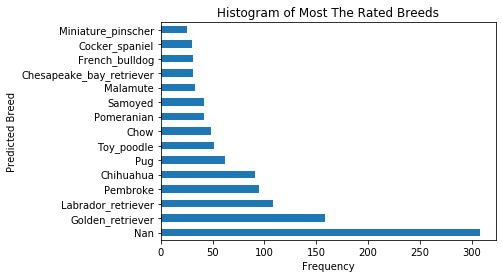

In [135]:
#Visualization for the Predicted breed from the algorithm
df_by_breed = master_df.groupby('Predicted_Breed').filter(lambda x: len(x) >= 25)

df_by_breed['Predicted_Breed'].value_counts().plot(kind = 'barh')
plt.title('Histogram of Most The Rated Breeds')
plt.xlabel('Frequency')
plt.ylabel('Predicted Breed');

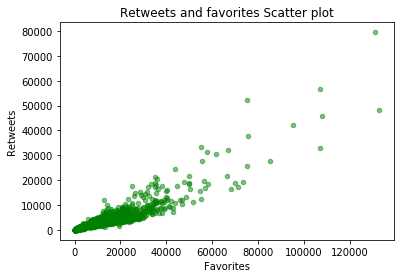

In [136]:
#Visualization for comparing favorites and retweets
master_df.plot(kind = 'scatter', x = 'Favorites', y = 'Retweets', alpha = 0.5, color = 'green')
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot');